### 라이브러리

In [7]:
# !pip install lightgbm
# !pip install optuna

     ------------------------------------- 308.2/308.2 KB 18.6 MB/s eta 0:00:00
     ---------------------------------------- 81.0/81.0 KB 4.4 MB/s eta 0:00:00
     ---------------------------------------- 147.0/147.0 KB ? eta 0:00:00
     ---------------------------------------- 49.7/49.7 KB 2.6 MB/s eta 0:00:00
     -------------------------------------- 112.3/112.3 KB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 95.2/95.2 KB ? eta 0:00:00


In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import warnings
# Ignore display of unnecessary warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# data preprocessing libs
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# model
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import optuna # 하이퍼파라미터 튜닝 최신 Automl 기법
from optuna import Trial, visualization
from optuna.samplers import TPESampler
# from optuna.integration import XGBoostPruningCallback
# import re

### 데이터 로드

In [296]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [297]:
train.tail()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
1103,1103,1956,Graduation,Together,46097.0,0,1,31-03-2013,11,5,...,6,4,0,0,0,0,0,0,0,241
1104,1104,1986,Graduation,Married,23477.0,1,0,21-10-2013,39,3,...,4,8,0,0,0,0,0,0,0,147
1105,1105,1975,Master,Married,37368.0,1,0,16-12-2013,4,1,...,2,6,1,0,0,0,0,0,0,30
1106,1106,1974,Graduation,Divorced,53034.0,1,1,30-05-2013,30,8,...,7,8,0,0,0,0,0,0,0,447
1107,1107,1952,PhD,Divorced,46610.0,0,2,29-10-2012,8,6,...,6,6,0,0,0,0,0,0,1,302


In [298]:
test.tail()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
1103,1103,1952,Graduation,Married,35704.0,1,1,03-01-2014,54,3,...,0,4,4,0,0,0,0,0,0,0
1104,1104,1969,Master,Together,35924.0,1,1,23-03-2014,56,1,...,0,3,5,0,0,0,0,0,0,0
1105,1105,1989,PhD,Single,33996.0,0,0,11-09-2013,46,1,...,1,3,4,0,0,0,0,0,0,0
1106,1106,1970,Graduation,Together,74854.0,1,2,08-04-2013,90,7,...,5,5,5,0,0,0,0,0,0,0
1107,1107,1975,Master,Single,46098.0,1,1,18-08-2012,86,4,...,2,2,8,0,0,0,0,0,0,0


-	id : 샘플 아이디
-	Year_Birth : 고객 생년월일
-	Education : 고객 학력
-	Marital_status : 고객 결혼 상태
-	Income : 고객 연간 가구 소득
-	Kidhome : 고객 가구의 자녀 수
-	Teenhome : 고객 가구의 청소년 수
-	Dt_Customer : 고객이 회사에 등록한 날짜
-	Recency : 고객의 마지막 구매 이후 일수
-	NumDealsPurchases : 할인된 구매 횟수
-	NumWebPurchases : 회사 웹사이트를 통한 구매 건수
-	NumCatalogPurchases : 카탈로그를 사용한 구매 수 
-	NumStorePuchases : 매장에서 직접 구매한 횟수
-	NumWebVisitsMonth : 지난 달 회사 웹사이트 방문 횟수
-	AcceptedCmp1: 고객이 첫 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
-	AcceptedCmp2: 고객이 두 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
-	AcceptedCmp3: 고객이 세 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
-	AcceptedCmp4: 고객이 네 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
-	AcceptedCmp5: 고객이 5번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
-	Complain : 고객이 지난 2년 동안 불만을 제기한 경우 1, 그렇지 않은 경우 0
-	Response : 고객이 마지막 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
-	target : 고객의 제품 총 소비량

In [299]:
print(train.shape)
test.shape

(1108, 22)


(1108, 21)

train 데이터와 test 데이터가 이미 분리되어있음. id컬럼이 겹침.  
예측변수 : target (train 데이터에만 들어있음)

In [300]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

In [301]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Dt_Customer          1108 non-null   object 
 8   Recency              1108 non-null   int64  
 9   NumDealsPurchases    1108 non-null   int64  
 10  NumWebPurchases      1108 non-null   int64  
 11  NumCatalogPurchases  1108 non-null   int64  
 12  NumStorePurchases    1108 non-null   int64  
 13  NumWebVisitsMonth    1108 non-null   int64  
 14  AcceptedCmp3         1108 non-null   int64  
 15  AcceptedCmp4         1108 non-null   i

22개의 피처 중 고유번호 id와 1개의 target 컬럼 존재  
AcceptedCmp, Complain, Respone 피처는 int형이지만 예/아니오 로 binary한 값을 가지고 있음.  
Education과 marital_status는 범주형 변수임.
고객이 회사에 등록한 날짜 Dt_Customer는 날짜데이터 타입이 아니라 문자열로 되어있음.  
데이터가 수치형과 범주형 데이터로 주로 구성되어있음.

In [302]:
# 결측치 확인
train.isnull().sum()

id                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
target                 0
dtype: int64

In [303]:
test.isnull().sum()

id                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
dtype: int64

----------------------------

### 데이터 전처리 & EDA(데이터 탐색)

In [304]:
train.describe() 

,id,Year_Birth,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
count,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.00000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000
mean,553.500000,1968.701264,52075.809567,0.429603,0.511733,50.156137,2.33935,4.184116,2.690433,5.905235,5.348375,0.069495,0.085740,0.072202,0.068592,0.015343,0.009025,0.141697,617.121841
std,319.996354,12.225380,21310.093395,0.545582,0.551624,29.085582,1.94328,2.810556,2.792236,3.306812,2.405115,0.254408,0.280106,0.258939,0.252873,0.122968,0.094614,0.348896,603.587972
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,276.750000,1959.000000,35768.500000,0.000000,0.000000,25.000000,1.00000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.750000
50%,553.500000,1970.000000,51609.500000,0.000000,0.000000,51.000000,2.00000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,412.000000
75%,830.250000,1977.000000,68325.000000,1.000000,1.000000,76.000000,3.00000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1068.750000
max,1107.000000,1996.000000,162397.000000,2.000000,2.000000,99.000000,15.00000,27.000000,11.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2525.000000


In [305]:
test.describe()

,id,Year_Birth,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
count,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000
mean,553.500000,1968.939531,52418.693141,0.453971,0.499097,47.869134,2.307762,3.986462,2.651625,5.696751,5.289711,0.077617,0.062274,0.074007,0.059567,0.011733,0.009928,0.158845
std,319.996354,11.745146,28526.498074,0.528033,0.536810,28.778160,1.904697,2.667140,3.056459,3.191864,2.446169,0.267689,0.241762,0.261901,0.236789,0.107730,0.099187,0.365696
min,0.000000,1899.000000,2447.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,276.750000,1959.750000,34678.000000,0.000000,0.000000,23.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,553.500000,1970.000000,51171.500000,0.000000,0.000000,47.000000,2.000000,3.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,830.250000,1977.000000,68695.000000,1.000000,1.000000,72.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1107.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,15.000000,25.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [306]:
train['Dt_Customer'] = pd.to_datetime(train['Dt_Customer'])
test['Dt_Customer'] = pd.to_datetime(test['Dt_Customer'])

In [307]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   1108 non-null   int64         
 1   Year_Birth           1108 non-null   int64         
 2   Education            1108 non-null   object        
 3   Marital_Status       1108 non-null   object        
 4   Income               1108 non-null   float64       
 5   Kidhome              1108 non-null   int64         
 6   Teenhome             1108 non-null   int64         
 7   Dt_Customer          1108 non-null   datetime64[ns]
 8   Recency              1108 non-null   int64         
 9   NumDealsPurchases    1108 non-null   int64         
 10  NumWebPurchases      1108 non-null   int64         
 11  NumCatalogPurchases  1108 non-null   int64         
 12  NumStorePurchases    1108 non-null   int64         
 13  NumWebVisitsMonth    1108 non-nul

In [308]:
import datetime

train['year'] = train['Dt_Customer'].dt.year
train['month'] = train['Dt_Customer'].dt.month
train['day'] = train['Dt_Customer'].dt.day

test['year'] = test['Dt_Customer'].dt.year
test['month'] = test['Dt_Customer'].dt.month
test['day'] = test['Dt_Customer'].dt.day

In [309]:
# 필요없는 컬럼 삭제

train.drop('Dt_Customer', axis=1, inplace=True)
test.drop('Dt_Customer', axis=1, inplace=True)

In [310]:
train.shape

(1108, 24)

In [311]:
test.shape

(1108, 23)

In [312]:
# 범주형
categorical = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
               'Complain', 'Response']
# 수치형
quantitative = ['Year_Birth', 'Income', 'year',	'month', 'day', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

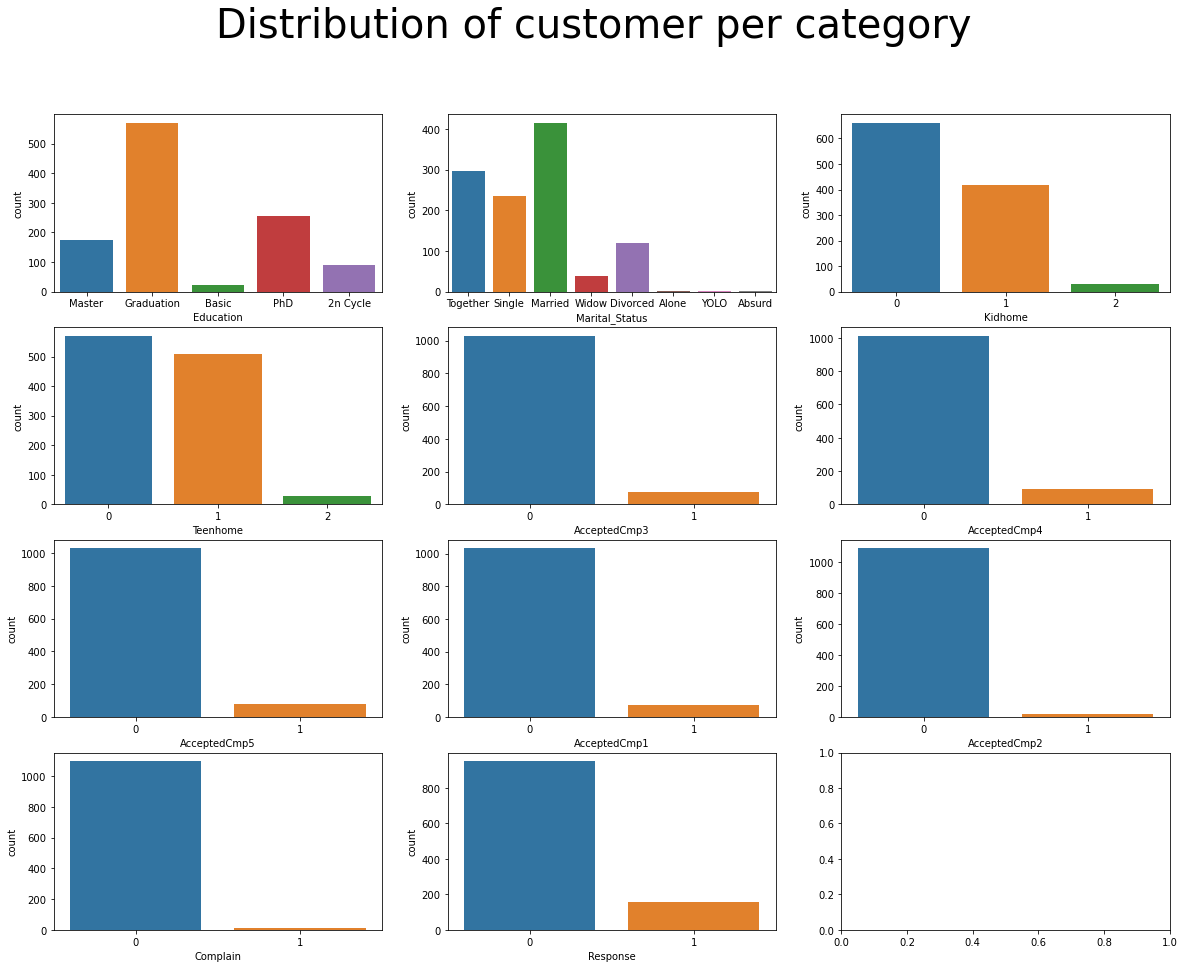

In [313]:
fig, axes = plt.subplots(4,3, figsize=(20,15))
fig.suptitle('Distribution of customer per category', fontsize=40)

for ax, feature in zip(axes.flatten(), categorical):
    sns.countplot(data = train, x = feature, ax=ax)
plt.show()

1. Marital_Status에서 'Alone', 'YOLO', 'Absurd'는 데이터가 극히 작고 Single에 범주에 포함되므로 single로 통합시켜 분석할 수도 있음. 
2. Kidhome와 Teenhome에서 자녀 및 청소년을 2명둔 사람은 소수라고 볼 수 있음.
3. AcceptedCmp1~5에서 보면, 1의 데이터가 적으므로 켐페인에 참여한 사람은 소수라고 볼 수 있음. 


In [314]:
# 캠페인 제안 횟수 합
train['AcceptedCmp'] = train["AcceptedCmp1"]+train["AcceptedCmp1"]+train["AcceptedCmp2"]+train["AcceptedCmp3"]+train["AcceptedCmp4"]+train["AcceptedCmp5"]
test['AcceptedCmp'] = test["AcceptedCmp1"]+test["AcceptedCmp1"]+test["AcceptedCmp2"]+test["AcceptedCmp3"]+test["AcceptedCmp4"]+test["AcceptedCmp5"]

In [315]:
train.columns

Index(['id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'target', 'year', 'month',
       'day', 'AcceptedCmp'],
      dtype='object')

In [316]:
train = train.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2'],axis =1)
test = test.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2'],axis =1)

In [317]:
test.columns

Index(['id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Complain', 'Response', 'year', 'month', 'day', 'AcceptedCmp'],
      dtype='object')

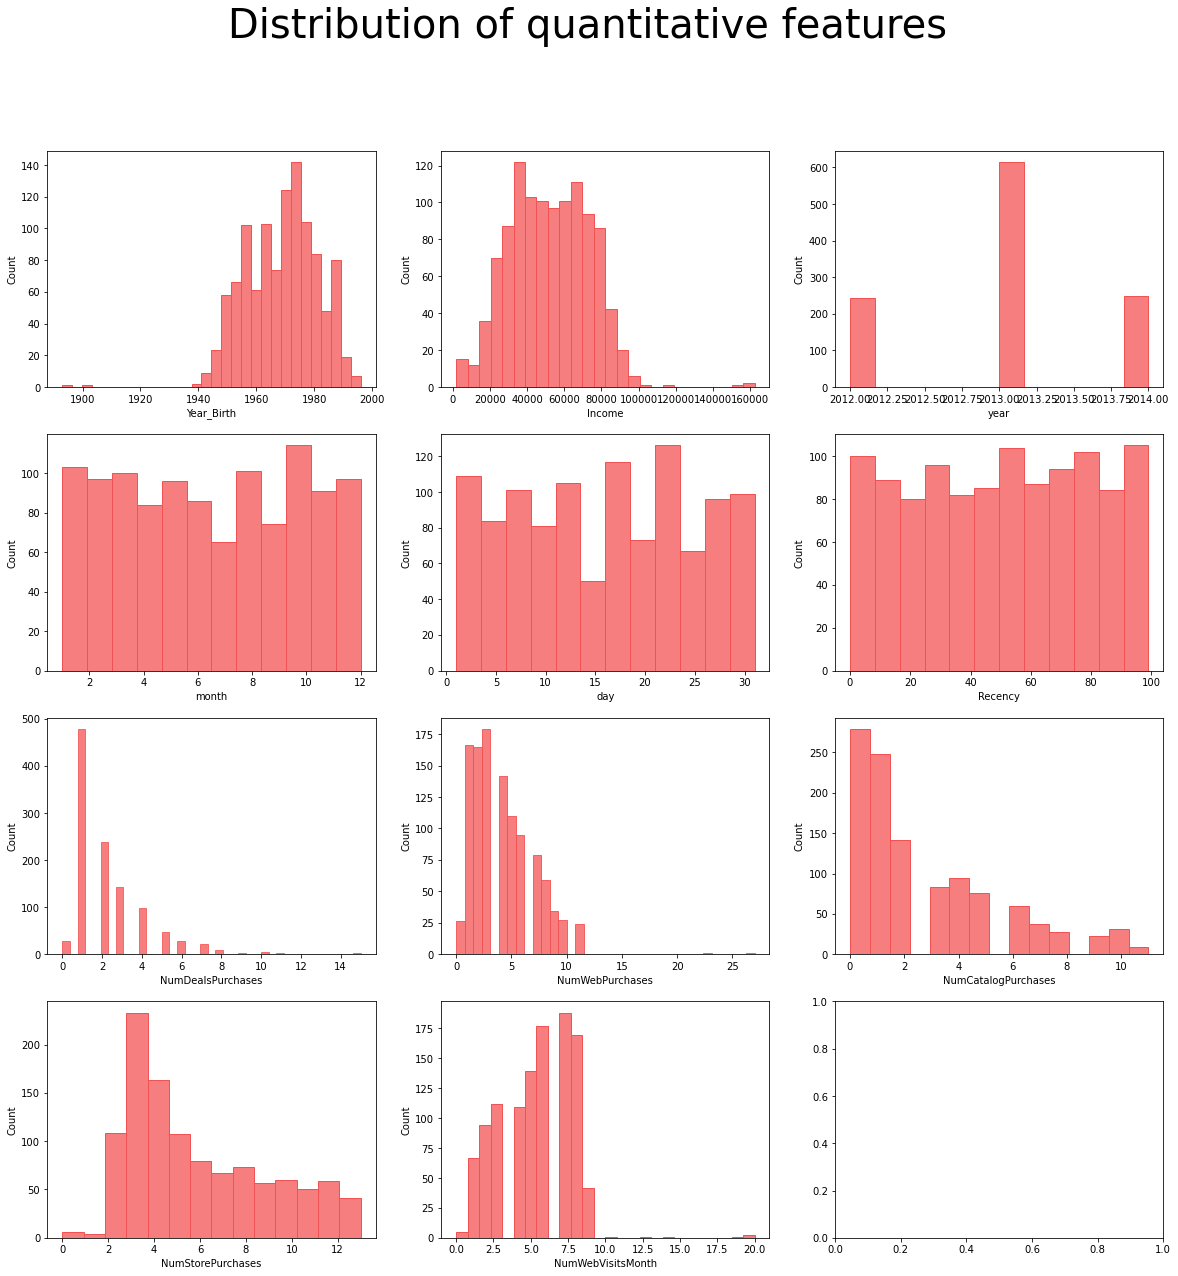

In [318]:
# 수치형 데이터 탐색
fig, axes = plt.subplots(4, 3, figsize=(20,20))
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

for ax,feature in zip(axes.flatten(),quantitative):
    sns.histplot(data = train, x = feature, ax=ax, color='#f55354', edgecolor='#f15354')
plt.show()

1. Year_Birth에서 1970 ~ 1980년생의 거래건수가 가장 많이 발생했다고 볼 수 있음.
2. Income에서 30000~70000 사이 가구 소득의 거래건수가 가장 많았다고 볼 수 있음.
3. year에서 13년도에 가장 거래건수가 많았다고 볼 수 있습니다.
4. Year_Birth, income, NumDealsPurchases, NumWebPurchases, NumWebVisitsMonth에서 이상치 발생 가능성을 볼 수 있음.

<Figure size 432x288 with 0 Axes>

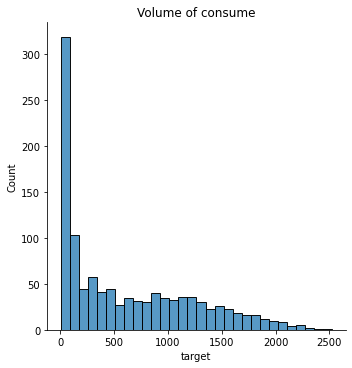

In [319]:
# train target distribution

plt.figure()
sns.displot(train['target'], bins=30)
plt.xlabel('target')
plt.title('Volume of consume')
plt.show()

소비량 분포가 왼쪽으로 치우쳐져있음.  
예측 회귀모형에 영향을 줄 수 있으니 로그 변환으로 정규화 실행한후 추후 다시 역변환

In [320]:
# 타겟 로그 변환 및 저장
train['log_target'] = np.log1p(train['target'])
real_target = train['target']
train.drop('target', axis=1, inplace=True)
train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,year,month,day,AcceptedCmp,log_target
0,0,1974,Master,Together,46014.0,1,1,21,10,7,1,8,7,0,0,2013,1,21,0,6.295266
1,1,1962,Graduation,Single,76624.0,0,1,68,1,5,10,7,1,0,0,2014,5,24,1,6.802395
2,2,1951,Graduation,Married,75903.0,0,1,50,2,6,6,9,3,0,0,2013,8,4,0,6.804615
3,3,1974,Basic,Married,18393.0,1,0,2,2,3,0,3,8,0,0,2014,3,29,0,3.931826
4,4,1946,PhD,Together,64014.0,2,1,56,7,8,2,5,7,0,0,2014,10,6,2,6.098074


In [321]:
real_target

0       541
1       899
2       901
3        50
4       444
       ... 
1103    241
1104    147
1105     30
1106    447
1107    302
Name: target, Length: 1108, dtype: int64

<Figure size 432x288 with 0 Axes>

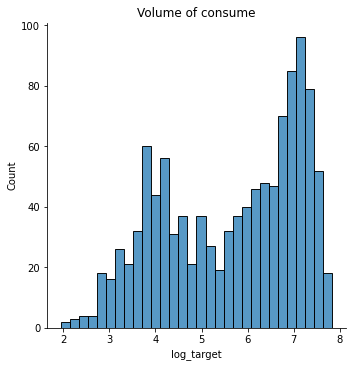

In [322]:
plt.figure()
sns.displot(train['log_target'], bins=30)
plt.xlabel('log_target')
plt.title('Volume of consume')
plt.show()

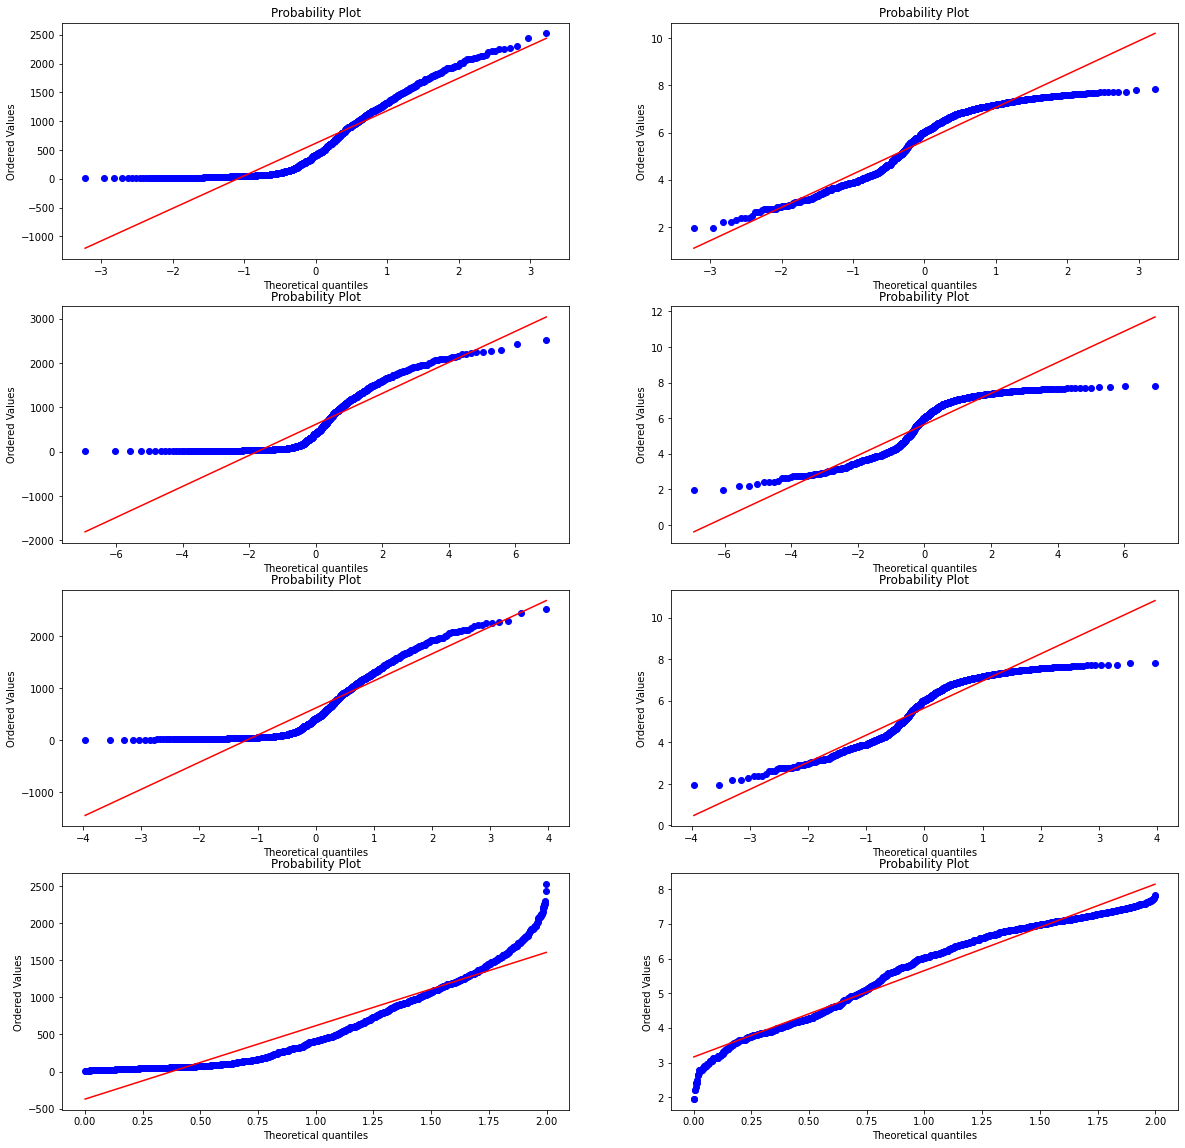

In [323]:
# QQ plot
from scipy import stats 

fig = plt.figure(figsize = (20,20))

fig.add_subplot(4,2,1)
res = stats.probplot(real_target, dist=stats.norm, plot=plt)

fig.add_subplot(4,2,2)
res = stats.probplot(train['log_target'], dist=stats.norm, plot=plt)

fig.add_subplot(4,2,3)
res = stats.probplot(real_target, dist = stats.hypsecant, plot=plt)

fig.add_subplot(4,2,4)
res = stats.probplot(train['log_target'], dist = stats.hypsecant, plot=plt)

fig.add_subplot(4,2,5)
res = stats.probplot(real_target, dist = stats.t(15), plot=plt)

fig.add_subplot(4,2,6)
res = stats.probplot(train['log_target'], dist = stats.t(15), plot=plt)

fig.add_subplot(4,2,7)
res = stats.probplot(real_target, dist = stats.uniform(0,2), plot=plt)

fig.add_subplot(4,2,8)
res = stats.probplot(train['log_target'], dist = stats.uniform(0,2), plot=plt)

qq-plot 그래프를 보면 로그를 취할 때 조금이나마 덜 튀는 성향이 보임.

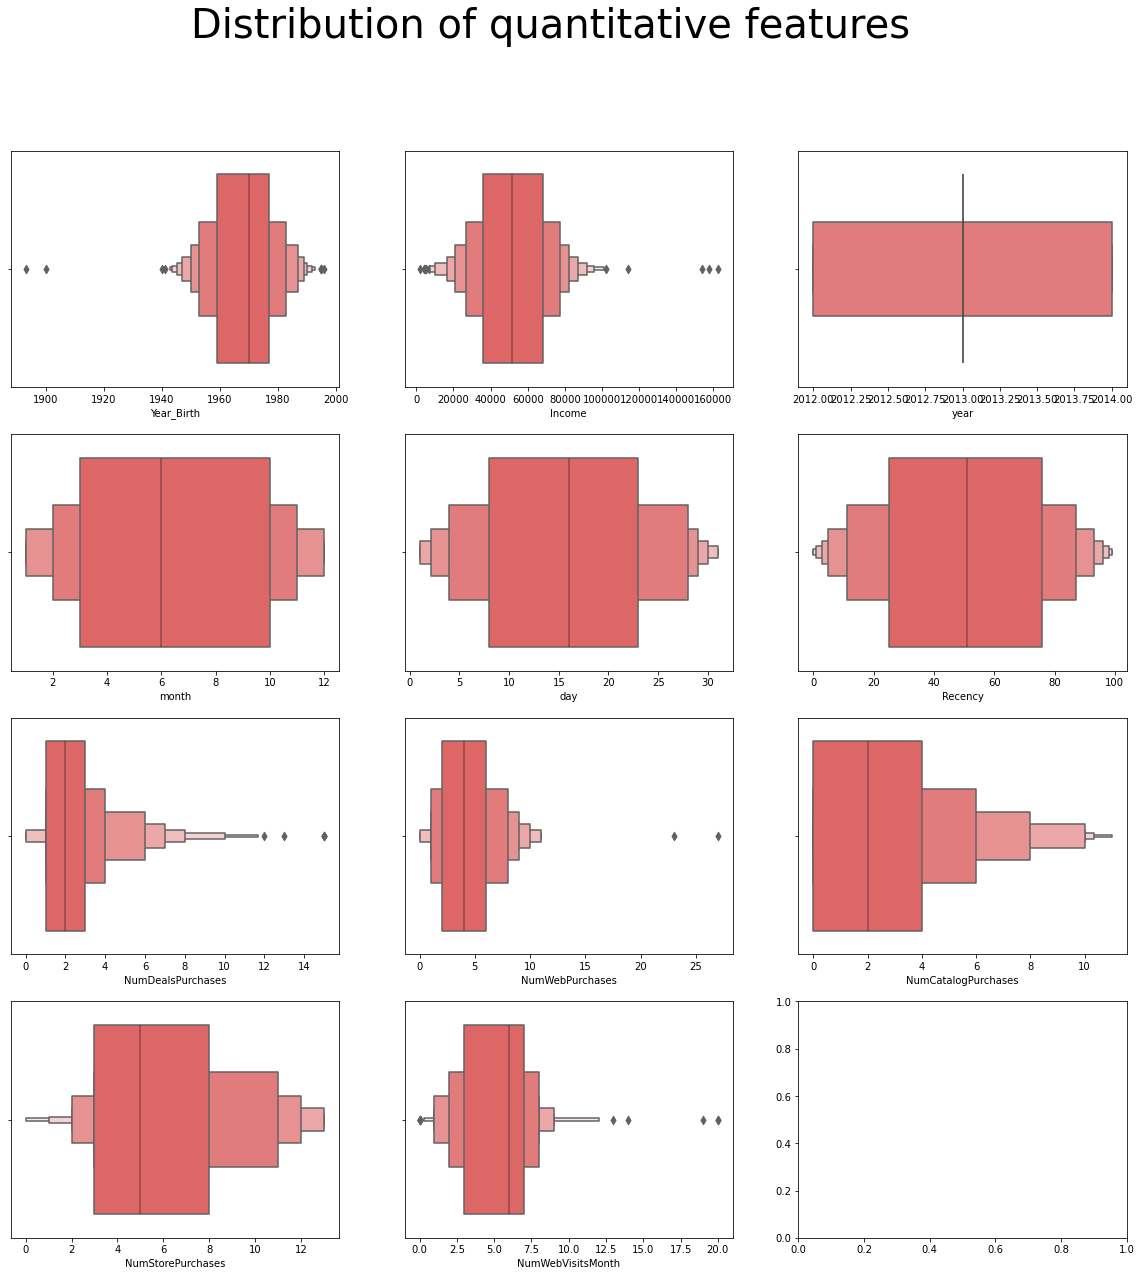

In [324]:
# 이상치 탐색
fig, axes = plt.subplots(4, 3, figsize=(20,20))
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

for ax,feature in zip(axes.flatten(),quantitative):
    sns.boxenplot(data = train, x = feature, ax=ax, color='#f15354')
plt.show()

IQR을 이용하여 이상치의 최대 제한선을 구하고 그 사이 범위를 구해보겠습니다.  
  
IQR 은 Interquartile range의 약자로써 사분위수의 상위 75% 지점의 값과 하위 25% 지점의 값 차이 (Q3 - Q1)를 의미  

In [325]:
# IQR
from scipy import stats
def IQR(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return lower_bound, upper_bound

outliers = train[quantitative].apply(lambda column: IQR(column))
print('Range of outliers by method')
outliers

Range of outliers by method


,Year_Birth,Income,year,month,day,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,1932.0,-13066.25,2013.0,-7.5,-14.5,-51.5,-2.0,-4.0,-6.0,-4.5,-3.0
1,2004.0,117159.75,2013.0,20.5,45.5,152.5,6.0,12.0,10.0,15.5,13.0


In [326]:
def IQRsum(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return ((column < lower_bound) | (column > upper_bound)).sum()

outliers = train[quantitative].drop(['year', 'month', 'day'], axis = 1).apply(lambda column: IQRsum(column))
print('Number of outliers by method')
outliers

Number of outliers by method


Year_Birth              2
Income                  3
Recency                 0
NumDealsPurchases      46
NumWebPurchases         2
NumCatalogPurchases     9
NumStorePurchases       0
NumWebVisitsMonth       4
dtype: int64

NumDealsPurchases 변수가 이상치가 높게 나왔으나 밑의 상관관계에서 낮은 양의 상관관계를 보여 참고하지 않을 변수라 따로 처리하지 않음.

Text(0.5, 1.0, 'Correlation between features')

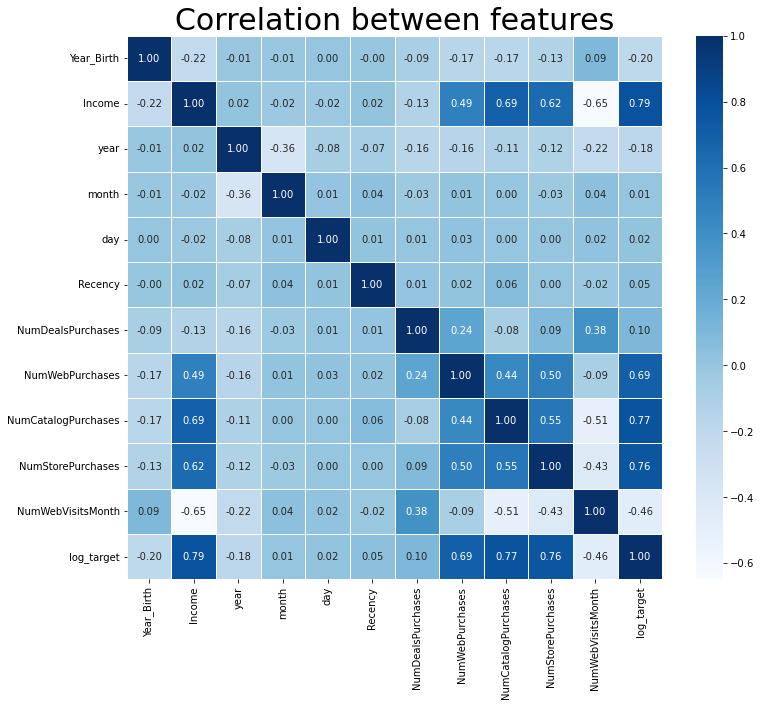

In [327]:
# 상관관계 pearson
quantitative.append('log_target')
# 수치형 데이터 상관관계 히트맵 시각화
train_corr = train[quantitative]
scaler= MinMaxScaler() 
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

In [328]:
# Target과 피쳐들의 상관관계
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['log_target'].sort_values(ascending=False), columns=['log_target'])
df_temp28.style.background_gradient(cmap='viridis')

,log_target
log_target,1.000000
Income,0.787190
NumCatalogPurchases,0.768924
NumStorePurchases,0.761083
NumWebPurchases,0.691052
NumDealsPurchases,0.103096
Recency,0.045280
day,0.017710
month,0.006698
year,-0.183592


우리가 가장 관심있는 것은 총 제품 소비량와 어떤 컬럼이 가장 상관관계가 높은가 입니다.

그래프를 보니 수치형데이터에서 income, NumCatalogPurchases, NumStorePurchases, NumWebPurchases가 가장 높은 양의 상관관계가 있는것으로 나타남.

이는 수입과 구매 수가 많을수록 제품 소비량이 늘어나는 것으로 해석할 수 있음.

범주형 : Education, Marital_Status + 수치형 : Income, NumCatalogPurchases, NumStorePurchases, NumWebPurchases 활용

In [329]:
print(train['Education'].unique())
print(train['Marital_Status'].unique())

['Master' 'Graduation' 'Basic' 'PhD' '2n Cycle']
['Together' 'Single' 'Married' 'Widow' 'Divorced' 'Alone' 'YOLO' 'Absurd']


In [330]:
# Label Encoding

le = LabelEncoder()
#train
le.fit(train['Education'])
train['Education'] = le.transform(train['Education'])
le.fit(train['Marital_Status'])
train['Marital_Status'] = le.transform(train['Marital_Status'])

#test
le.fit(test['Education'])
test['Education'] = le.transform(test['Education'])
le.fit(test['Marital_Status'])
test['Marital_Status'] = le.transform(test['Marital_Status'])

회귀예측을 위한 XGBoost와 LightGBM에서 모델학습할 때 오류방지를 위해 int형으로 변환

In [331]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   int32  
 3   Marital_Status       1108 non-null   int32  
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Recency              1108 non-null   int64  
 8   NumDealsPurchases    1108 non-null   int64  
 9   NumWebPurchases      1108 non-null   int64  
 10  NumCatalogPurchases  1108 non-null   int64  
 11  NumStorePurchases    1108 non-null   int64  
 12  NumWebVisitsMonth    1108 non-null   int64  
 13  Complain             1108 non-null   int64  
 14  Response             1108 non-null   int64  
 15  year                 1108 non-null   i

In [332]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   int32  
 3   Marital_Status       1108 non-null   int32  
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Recency              1108 non-null   int64  
 8   NumDealsPurchases    1108 non-null   int64  
 9   NumWebPurchases      1108 non-null   int64  
 10  NumCatalogPurchases  1108 non-null   int64  
 11  NumStorePurchases    1108 non-null   int64  
 12  NumWebVisitsMonth    1108 non-null   int64  
 13  Complain             1108 non-null   int64  
 14  Response             1108 non-null   int64  
 15  year                 1108 non-null   i

In [333]:
train.columns

Index(['id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Complain', 'Response', 'year', 'month', 'day', 'AcceptedCmp',
       'log_target'],
      dtype='object')

In [334]:
train = train[['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases','Complain','Response','AcceptedCmp','log_target']]
test  = test [['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases','Complain','Response','AcceptedCmp']]

# Modeling

1. 여러개의 모델을 사용해서 비교하고, 가장 낮은 NMAE가 나온 모델을 선정해 튜닝을 하겠습니다.  
소비량 예측하는 회귀 모형을 사용합니다.  

모델 목록  
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elasticnet Regression
- Decision Tree
- RandomForest Regressor
- XGBoost Regressor
- LightGBM Regressor

In [335]:
train_X, train_y = train.drop('log_target', axis=1), train['log_target']
print(train_X.shape, train_y.shape)

(1108, 12) (1108,)


In [336]:
train_y

0       6.295266
1       6.802395
2       6.804615
3       3.931826
4       6.098074
          ...   
1103    5.488938
1104    4.997212
1105    3.433987
1106    6.104793
1107    5.713733
Name: log_target, Length: 1108, dtype: float64

In [337]:
import numpy as np
from sklearn.model_selection import KFold

def NMAE(y, y_pred):
    score = np.mean(np.abs(y - y_pred) / y)
    return score

def nmae_cv(model):
    kf = KFold(n_splits=10)
    kf.get_n_splits(train_X)
    # cv별로 학습하는 함수
    nmae_list = []
    model_name = model.__class__.__name__
    for train_index, test_index in kf.split(train_X):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        nmae = NMAE(np.array(y_test), pred)
        nmae_list.append(nmae)
    return model_name, nmae_list

def print_nmae_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = nmae_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} NMAE: {r:.4f}')
        print(f'\n{model_name} mean NMAE: {np.mean(score):.4f}')
        print('='*40)
    return model_name, np.mean(score)

In [338]:
# import numpy as np
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=10)
# kf.get_n_splits(train_X)

# # cv별로 학습하는 함수
# nmae_list = []
# model_name = model.__class__.__name__
# for train_index, test_index in kf.split(train_X):
#     X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
#     y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
#     clf = model.fit(X_train, y_train)
#     pred = clf.predict(X_test)
#     nmae = NMAE(np.array(y_test), pred)
#     nmae_list.append(nmae)

In [339]:
# 모델 정의
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [340]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
    model_name, mean_score = print_nmae_score(model)
    models.append(model_name)
    scores.append(mean_score)

1 FOLDS: LinearRegression NMAE: 0.0914

LinearRegression mean NMAE: 0.0845
2 FOLDS: LinearRegression NMAE: 0.0817

LinearRegression mean NMAE: 0.0845
3 FOLDS: LinearRegression NMAE: 0.0812

LinearRegression mean NMAE: 0.0845
4 FOLDS: LinearRegression NMAE: 0.0706

LinearRegression mean NMAE: 0.0845
5 FOLDS: LinearRegression NMAE: 0.0718

LinearRegression mean NMAE: 0.0845
6 FOLDS: LinearRegression NMAE: 0.0850

LinearRegression mean NMAE: 0.0845
7 FOLDS: LinearRegression NMAE: 0.1034

LinearRegression mean NMAE: 0.0845
8 FOLDS: LinearRegression NMAE: 0.0841

LinearRegression mean NMAE: 0.0845
9 FOLDS: LinearRegression NMAE: 0.0765

LinearRegression mean NMAE: 0.0845
10 FOLDS: LinearRegression NMAE: 0.0991

LinearRegression mean NMAE: 0.0845
1 FOLDS: Ridge NMAE: 0.0914

Ridge mean NMAE: 0.0845
2 FOLDS: Ridge NMAE: 0.0817

Ridge mean NMAE: 0.0845
3 FOLDS: Ridge NMAE: 0.0813

Ridge mean NMAE: 0.0845
4 FOLDS: Ridge NMAE: 0.0706

Ridge mean NMAE: 0.0845
5 FOLDS: Ridge NMAE: 0.0718

Ridge me

In [341]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,0.084494
1,Ridge,0.084490
2,Lasso,0.084988
3,ElasticNet,0.084592
4,DecisionTreeRegressor,0.055978
5,RandomForestRegressor,0.051442
6,XGBRegressor,0.041456
7,LGBMRegressor,0.041128


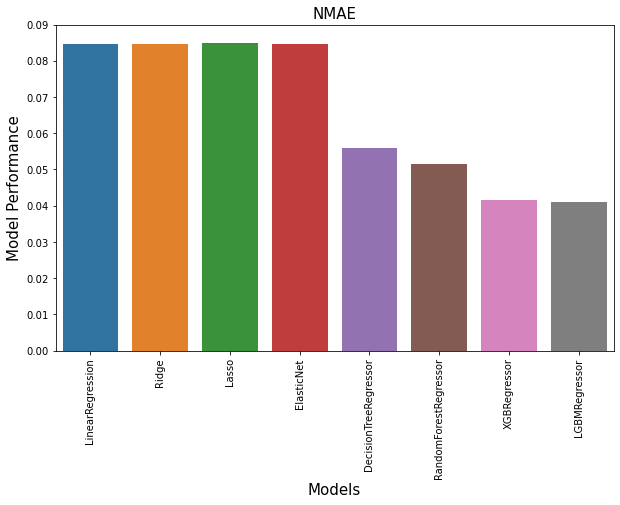

In [342]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.00, 0.09)
plt.title('NMAE', fontsize=15)
plt.show()

실행결과 LightGBM, XGBoost가 0.041 정도로 가장 작은 것으로 나옴.

# 하이퍼파라미터 튜닝

In [343]:
# 8:2 분할 검증데이터 사전작업

cut = int(len(train)*0.8)
h_train = train[:cut]
h_valid = train[cut:]

h_train_X = h_train.drop('log_target', axis=1)
h_train_y = h_train['log_target']
h_valid_X = h_valid.drop('log_target', axis=1)
h_valid_y = h_valid['log_target']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(886, 12) (886,) (222, 12) (222,)


### LightGBM

In [344]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(h_train_X, label=h_train_y)
    dtest = lgb.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    nmae = NMAE(h_valid_y, lgb_model.predict(h_valid_X))
    return nmae
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=1000)

[I 2022-05-12 11:15:34,232] A new study created in memory with name: no-name-d7d3122a-6e42-481c-842e-82dc5b61a72f
[I 2022-05-12 11:15:34,586] Trial 0 finished with value: 0.26691929007037807 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.26691929007037807.
[I 2022-05-12 11:15:35,219] Trial 1 finished with value: 0.2668341966685164 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 0.2668341966685164.
[I 2022-05-12 11:15:35,254] Trial 2 finished with value: 0.15772333718566559 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 0.15772333718566559.
[I 2022-05-12 11:15:35,390] Trial 3 finished w

In [345]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.04023197759772068,
params {'max_depth': 5, 'learning_rate': 0.009887482086047129, 'n_estimators': 2379, 'min_child_samples': 5, 'subsample': 0.6698134400821205}


### XGBoost

In [346]:
# XGB 하이퍼 파라미터들 값 지정
def objectiveXGB(trial: Trial, X, y, test):
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000),
        'max_depth' : trial.suggest_int('max_depth', 8, 16),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 300),
        'gamma' : trial.suggest_int('gamma', 1, 3),
        'learning_rate' : 0.01,
        'colsample_bytree' : trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'nthread' : -1,
        # 'tree_method' : 'gpu_hist',
        # 'predictor' : 'gpu_predictor',
        'lambda' : trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha' : trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'subsample' : trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
        'random_state' : 1127
    }
    
    # 학습 모델 생성
    model = XGBRegressor(**param)
    xgb_model = model.fit(X, y, verbose=True) # 학습 진행
    
    # 모델 성능 확인
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [347]:
# MAE가 최소가 되는 방향으로 학습을 진행
# TPESampler : Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective, n_trials=1000)

# n_trials 지정해주지 않으면, 무한 반복
# study_xgb.optimize(lambda trial : objectiveXGB(trial, h_train_X, h_train_y, train_y), n_trials = 50)

[I 2022-05-12 11:24:43,140] A new study created in memory with name: no-name-fa5112a7-a1a7-46fe-b639-afdfa8280ced
[I 2022-05-12 11:24:44,240] Trial 0 finished with value: 0.22631032351864208 and parameters: {'max_depth': 8, 'learning_rate': 3.6371586692643706e-08, 'n_estimators': 2482, 'min_child_samples': 19, 'subsample': 0.5687409490746276}. Best is trial 0 with value: 0.22631032351864208.
[I 2022-05-12 11:24:44,488] Trial 1 finished with value: 0.04263865217739511 and parameters: {'max_depth': 15, 'learning_rate': 0.008428549649176586, 'n_estimators': 1423, 'min_child_samples': 84, 'subsample': 0.5036070677455403}. Best is trial 1 with value: 0.04263865217739511.
[I 2022-05-12 11:24:44,827] Trial 2 finished with value: 0.0439336230651815 and parameters: {'max_depth': 10, 'learning_rate': 0.002612104587991284, 'n_estimators': 1650, 'min_child_samples': 61, 'subsample': 0.41465965127808796}. Best is trial 1 with value: 0.04263865217739511.
[I 2022-05-12 11:24:45,100] Trial 3 finished 

In [349]:
trial = study_xgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.03598154286749051,
params {'max_depth': 5, 'learning_rate': 0.007263207014575167, 'n_estimators': 1798, 'min_child_samples': 5, 'subsample': 0.9601279053352578}


파라미터 조절결과 LighjtGBM은 0.041에서 0.040로 줄어들어 성능향상이 있음.  
파라미터 조절결과 XGBoost는 0.041에서 0.035로 줄어들어 더 높은 성능향상이 있음.

# Final XGBoost 제출

In [350]:
final_xgb_model = xgb.XGBRegressor(**trial_params)
final_xgb_model.fit(train_X, train_y)
final_xgb_pred = final_xgb_model.predict(test)
final_xgb_pred

[11:43:43] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "min_child_samples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




array([6.366022 , 6.670909 , 6.6118855, ..., 4.2341766, 6.9651275,
       4.7449074], dtype=float32)

<BarContainer object of 12 artists>

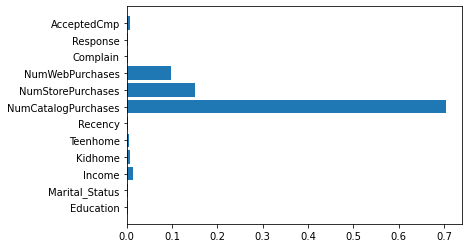

In [351]:
plt.barh(train_X.columns, final_xgb_model.feature_importances_)

NumCatalogPurchases, NumStorepurchase, NumWebPurchase 등 순으로 구매건수 중요도가 높다고 나옴.

In [352]:
# log를 취했던 값을 다시 역변환 시켜서 저장
final_pred_sub = np.expm1(final_xgb_pred)
final_pred_sub

array([ 580.73914 ,  788.11255 ,  742.88434 , ...,   68.00484 ,
       1058.0499  ,  113.997154], dtype=float32)

In [353]:
# 예측 target값 제출
sub = pd.read_csv('test.csv')
sub = pd.DataFrame({'id': sub['id'], 'target': final_pred_sub})
sub

,id,target
0,0,580.739136
1,1,788.112549
2,2,742.884338
3,3,1137.787842
4,4,1369.513672
...,...,...
1103,1103,79.437637
1104,1104,35.145866
1105,1105,68.004837
1106,1106,1058.049927


In [354]:
submission = pd.read_csv('sample_submission.csv')
submission

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
1103,1103,0
1104,1104,0
1105,1105,0
1106,1106,0


In [355]:
submission['target'] = sub['target']
submission.head()

,id,target
0,0,580.739136
1,1,788.112549
2,2,742.884338
3,3,1137.787842
4,4,1369.513672


In [356]:
submission.to_csv("submission_baseline6.csv", index=False)